# Convolutional Neural Networks

## Libraries

In [1]:
# !pip install torch
# !pip install torchvision
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=1a6cdcc360b89929a926650542e3e61ac924b3b3906057d5ea4b0fcfb90d3eb9
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [2]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
from medmnist import DermaMNIST
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

## Utilities

In [3]:
# Training function.
def train(epoch, model, loader, criterion, optimizer, device='cpu'):
    l = 0
    for data in tqdm(loader, desc=f'Epoch {epoch+1:03d}'):
        x = data[0].to(device)
        y = data[1].squeeze().to(device)
        out = model(x)
        loss = criterion(out, y)
        l += loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return l

# Test function.
def test(model, loader, criterion, device='cpu'):
    l = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in loader:
            x = data[0].to(device)
            y = data[1].squeeze().to(device)
            out = model(x)
            l += criterion(out, y)
            _, pred = torch.max(out.data, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            y_true += y.tolist()
            y_pred += pred.tolist()
    return l, correct / total, y_true, y_pred

## Data

[MedMNIST](https://medmnist.com/).

In [4]:
issubclass(DermaMNIST, torch.utils.data.Dataset)

True

In [5]:
# Training transformations.
train_transformations = transforms.Compose([
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

# Datasets.
train_dataset = DermaMNIST(split='train',
                           transform=train_transformations,
                           download=True,
                           size=224)
test_dataset = DermaMNIST(split='test',
                          transform=transforms.ToTensor(),
                          download=True,
                          size=224)

# Loaders.
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=64,
                                          shuffle=False)

100%|██████████| 1091112502/1091112502 [00:50<00:00, 21640723.12it/s]


Using downloaded and verified file: /root/.medmnist/dermamnist_224.npz


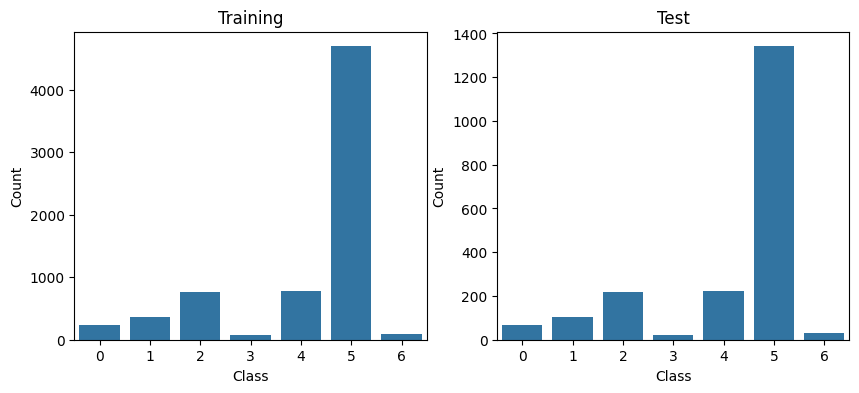

In [6]:
# From label index to label name.
labels_map = {
    0: 'actinic keratoses and intraepithelial carcinoma',
    1: 'basal cell carcinoma',
    2: 'benign keratosis-like lesions',
    3: 'dermatofibroma',
    4: 'melanoma',
    5: 'melanocytic nevi',
    6: 'vascular lesions'
}

# Training and test distributions.
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x=[label[0] for img, label in train_dataset], ax=ax[0])
sns.countplot(x=[label[0] for img, label in test_dataset], ax=ax[1])
ax[0].set_title('Training')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')
ax[1].set_title('Test')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')
plt.show()

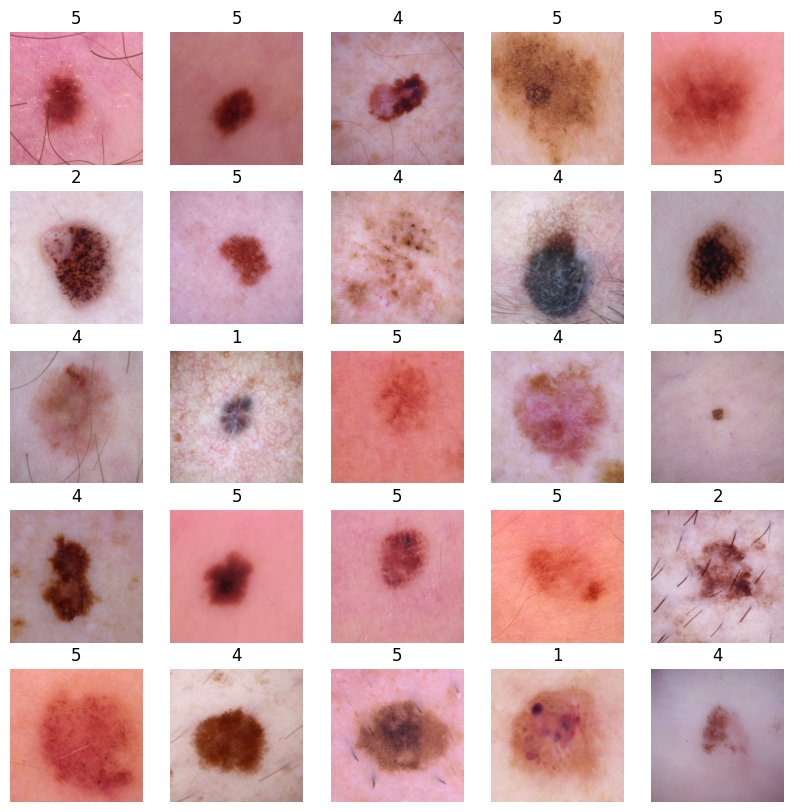

In [7]:
# Plotting 100 training images.
fig = plt.figure(figsize=(10, 10))
rows, cols = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    img, label = test_dataset[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(label[0])
    plt.axis('off')
    plt.imshow(img.moveaxis(0, -1))
plt.show()

## Model Definition

In [8]:
# Device configuration.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters.
num_classes = 7
num_epochs = 10
learning_rate = 0.001

# Convolutional neural network.
class ConvNet(nn.Module):

    # Constructor.
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.fc = nn.Linear(23 * 23 * 16, num_classes)

    # Forward pass.
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

# Create the model.
model = ConvNet(num_classes).to(device)

## Training and Test

In [9]:
# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and test.
for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, y_true, y_pred = test(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1:03d}: training loss {train_loss:.4f}, test loss {test_loss:.4f}, test acc {test_acc}')

Epoch 001: 100%|██████████| 110/110 [00:13<00:00,  8.01it/s]


Epoch 001: training loss 112.4481, test loss 30.9301, test acc 0.6693266832917706


Epoch 002: 100%|██████████| 110/110 [00:13<00:00,  8.40it/s]


Epoch 002: training loss 102.2433, test loss 29.5630, test acc 0.6638403990024938


Epoch 003: 100%|██████████| 110/110 [00:13<00:00,  8.41it/s]


Epoch 003: training loss 97.7944, test loss 27.4992, test acc 0.6743142144638404


Epoch 004: 100%|██████████| 110/110 [00:17<00:00,  6.29it/s]


Epoch 004: training loss 93.6641, test loss 26.9055, test acc 0.6972568578553616


Epoch 005: 100%|██████████| 110/110 [00:12<00:00,  8.94it/s]


Epoch 005: training loss 91.5396, test loss 26.5300, test acc 0.683291770573566


Epoch 006: 100%|██████████| 110/110 [00:12<00:00,  8.96it/s]


Epoch 006: training loss 91.4448, test loss 27.1399, test acc 0.6822942643391521


Epoch 007: 100%|██████████| 110/110 [00:12<00:00,  8.81it/s]


Epoch 007: training loss 88.8649, test loss 27.0929, test acc 0.6693266832917706


Epoch 008: 100%|██████████| 110/110 [00:12<00:00,  8.98it/s]


Epoch 008: training loss 88.1399, test loss 25.5420, test acc 0.6947630922693266


Epoch 009: 100%|██████████| 110/110 [00:12<00:00,  8.96it/s]


Epoch 009: training loss 86.6428, test loss 25.4184, test acc 0.6957605985037406


Epoch 010: 100%|██████████| 110/110 [00:12<00:00,  8.99it/s]


Epoch 010: training loss 84.1100, test loss 24.7518, test acc 0.6942643391521197


In [10]:
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.53      0.12      0.20        66
           1       0.39      0.40      0.39       103
           2       0.50      0.20      0.28       220
           3       1.00      0.04      0.08        23
           4       0.36      0.38      0.37       223
           5       0.78      0.90      0.83      1341
           6       0.92      0.38      0.54        29

    accuracy                           0.69      2005
   macro avg       0.64      0.35      0.38      2005
weighted avg       0.68      0.69      0.66      2005



In [11]:
# List of training labels.
train_targets = [label[0] for _, label in train_dataset]

# Computing class weights based on class frequency.
cls_weights = torch.from_numpy(compute_class_weight('balanced', classes=np.unique(train_targets), y=train_targets))

# Resulting array of weights.
weights = cls_weights[train_targets]

# Weighted random sampler. Used to consider copies of minority classes.
sampler = torch.utils.data.WeightedRandomSampler(weights, len(train_targets), replacement=True)

# Train loader.
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=sampler,
                                           batch_size=64)

In [12]:
# Create the model.
model = ConvNet(num_classes).to(device)

# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and test.
for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, y_true, y_pred = test(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1:03d}: training loss {train_loss:.4f}, test loss {test_loss:.4f}, test acc {test_acc}')

Epoch 001: 100%|██████████| 110/110 [00:12<00:00,  8.82it/s]


Epoch 001: training loss 187.8480, test loss 41.7423, test acc 0.47880299251870323


Epoch 002: 100%|██████████| 110/110 [00:12<00:00,  8.81it/s]


Epoch 002: training loss 152.1747, test loss 44.5582, test acc 0.4912718204488778


Epoch 003: 100%|██████████| 110/110 [00:12<00:00,  8.48it/s]


Epoch 003: training loss 134.6948, test loss 36.1844, test acc 0.5625935162094763


Epoch 004: 100%|██████████| 110/110 [00:12<00:00,  8.90it/s]


Epoch 004: training loss 127.7028, test loss 40.3731, test acc 0.5281795511221945


Epoch 005: 100%|██████████| 110/110 [00:12<00:00,  8.86it/s]


Epoch 005: training loss 120.4507, test loss 33.7257, test acc 0.598004987531172


Epoch 006: 100%|██████████| 110/110 [00:12<00:00,  8.87it/s]


Epoch 006: training loss 117.0468, test loss 32.9810, test acc 0.601496259351621


Epoch 007: 100%|██████████| 110/110 [00:12<00:00,  8.49it/s]


Epoch 007: training loss 114.4753, test loss 42.5123, test acc 0.5192019950124688


Epoch 008: 100%|██████████| 110/110 [00:13<00:00,  8.29it/s]


Epoch 008: training loss 112.0767, test loss 31.4401, test acc 0.6144638403990025


Epoch 009: 100%|██████████| 110/110 [00:12<00:00,  8.75it/s]


Epoch 009: training loss 111.1821, test loss 37.8438, test acc 0.5486284289276808


Epoch 010: 100%|██████████| 110/110 [00:12<00:00,  8.85it/s]


Epoch 010: training loss 106.2291, test loss 40.6517, test acc 0.5306733167082295


In [13]:
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.14      0.44      0.21        66
           1       0.27      0.62      0.38       103
           2       0.36      0.35      0.36       220
           3       0.10      0.61      0.17        23
           4       0.31      0.52      0.39       223
           5       0.96      0.55      0.70      1341
           6       0.36      0.79      0.49        29

    accuracy                           0.53      2005
   macro avg       0.36      0.56      0.39      2005
weighted avg       0.74      0.53      0.59      2005



## ResNet-18

In [14]:
# Download and load the pretrained ResNet-18.
resnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')

# Replace the top layer for finetuning.
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Move model to device.
resnet = resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


In [15]:
# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate)

# Training and test.
for epoch in range(num_epochs):
    train_loss = train(epoch, resnet, train_loader, criterion, optimizer, device)
    test_loss, test_acc, y_true, y_pred = test(resnet, test_loader, criterion, device)
    print(f'Epoch {epoch+1:03d}: training loss {train_loss:.4f}, test loss {test_loss:.4f}, test acc {test_acc}')

Epoch 001: 100%|██████████| 110/110 [00:20<00:00,  5.37it/s]


Epoch 001: training loss 97.7907, test loss 74.6923, test acc 0.33615960099750625


Epoch 002: 100%|██████████| 110/110 [00:20<00:00,  5.38it/s]


Epoch 002: training loss 65.5595, test loss 67.4459, test acc 0.3970074812967581


Epoch 003: 100%|██████████| 110/110 [00:19<00:00,  5.51it/s]


Epoch 003: training loss 56.8372, test loss 66.7783, test acc 0.4967581047381546


Epoch 004: 100%|██████████| 110/110 [00:19<00:00,  5.50it/s]


Epoch 004: training loss 47.9798, test loss 55.3523, test acc 0.5012468827930174


Epoch 005: 100%|██████████| 110/110 [00:20<00:00,  5.44it/s]


Epoch 005: training loss 40.1705, test loss 70.5958, test acc 0.4723192019950125


Epoch 006: 100%|██████████| 110/110 [00:20<00:00,  5.50it/s]


Epoch 006: training loss 39.4628, test loss 61.3838, test acc 0.5197007481296758


Epoch 007: 100%|██████████| 110/110 [00:19<00:00,  5.51it/s]


Epoch 007: training loss 37.4084, test loss 54.5123, test acc 0.5311720698254364


Epoch 008: 100%|██████████| 110/110 [00:19<00:00,  5.50it/s]


Epoch 008: training loss 29.4583, test loss 61.5077, test acc 0.5157107231920199


Epoch 009: 100%|██████████| 110/110 [00:20<00:00,  5.49it/s]


Epoch 009: training loss 30.2033, test loss 62.5843, test acc 0.5446384039900249


Epoch 010: 100%|██████████| 110/110 [00:19<00:00,  5.50it/s]


Epoch 010: training loss 28.3724, test loss 66.3690, test acc 0.5201995012468827


In [16]:
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.18      0.61      0.28        66
           1       0.35      0.76      0.48       103
           2       0.42      0.68      0.52       220
           3       0.23      0.91      0.37        23
           4       0.40      0.57      0.47       223
           5       0.96      0.45      0.61      1341
           6       0.17      1.00      0.29        29

    accuracy                           0.52      2005
   macro avg       0.39      0.71      0.43      2005
weighted avg       0.76      0.52      0.56      2005

